# Project Architecture 

## Goal

The main objective of this project is to classify Turkish emails as either "Legitimate" or "Phishing" by utilizing a Turkish phishing email dataset. The project aims to implement and compare different machine learning algorithms to evaluate their performance and effectiveness in detecting phishing emails.

## Import Libraries and Load Data

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast

In [38]:
# Load the dataset
df = pd.read_csv('turkish_phishing_dataset.csv')
df = df[['Konu', 'Gönderen', 'İçerik', 'Kategori']].dropna()
df['text'] = df['Konu'] + " " + df['Gönderen'] + " " + df['İçerik']
df['label'] = df['Kategori'].map({'Güvenilir': 0, 'Oltalama': 1})

# Split the data into train, validation, and test sets for BERT
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)  # 0.1765 = 0.15 / (1-0.15) to get 15% validation set

In [39]:
# --- Classical ML Models ---

# Feature Engineering for classical ML models (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(df['text']).toarray()
y = df['label'].values

# Scaling & Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)
print("Number of features after PCA:", X_pca.shape[1])

# Split the PCA-transformed data for classical ML models
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

Number of features after PCA: 21


In [40]:
# --- BERT Model ---

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')
bert_model = BertForSequenceClassification.from_pretrained(
    'dbmdz/bert-base-turkish-cased',
    num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Prepare data for BERT
MAX_LEN = 128

def prepare_bert_data(texts, labels, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values)
    
    return input_ids, attention_masks, labels

In [42]:
# Prepare training, validation, and test data for BERT
train_inputs, train_masks, train_labels = prepare_bert_data(X_train, y_train, tokenizer, MAX_LEN)
val_inputs, val_masks, val_labels = prepare_bert_data(X_val, y_val, tokenizer, MAX_LEN)
test_inputs, test_masks, test_labels = prepare_bert_data(X_test, y_test, tokenizer, MAX_LEN)

# Create DataLoaders for BERT with optimized settings
batch_size = 8  # Reduced batch size for GTX 1650Ti
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size,
    num_workers=0
)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size,
    num_workers=0
)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size,
    num_workers=0
)

In [43]:
# Set up device and move BERT model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

# Optimizer and scheduler for BERT
optimizer = AdamW(bert_model.parameters(), lr=2e-5, eps=1e-8)
epochs = 2  # Maximum epochs
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Mixed precision training setup
scaler = GradScaler()

# Gradient accumulation settings
accumulation_steps = 2  # Effective batch size = batch_size * accumulation_steps = 16

# Early stopping settings
best_val_loss = float('inf')
patience = 1  # Stop if validation loss doesn't improve for 1 epoch
patience_counter = 0

C:\Users\Windows\AppData\Local\Temp\ipykernel_12244\3872322393.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\Windows\AppData\Roaming\Python\Python312\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [44]:
# Train BERT with early stopping
def train_bert():
    bert_model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    for step, batch in enumerate(train_dataloader):
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)
        
        with autocast():
            outputs = bert_model(
                batch_input_ids,
                attention_mask=batch_attention_masks,
                labels=batch_labels
            )
            loss = outputs.loss / accumulation_steps
        
        scaler.scale(loss).backward()
        
        total_loss += loss.item() * accumulation_steps
        
        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
        
        if step % 10 == 0 and step != 0:
            print(f"Step {step}/{len(train_dataloader)} in epoch")
    
    return total_loss / len(train_dataloader)

In [45]:
# Evaluate BERT on validation set for early stopping
def evaluate_bert_val():
    bert_model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch_input_ids = batch[0].to(device)
            batch_attention_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)
            
            with autocast():
                outputs = bert_model(
                    batch_input_ids,
                    attention_mask=batch_attention_masks,
                    labels=batch_labels
                )
            loss = outputs.loss
            total_loss += loss.item()
    
    return total_loss / len(val_dataloader)

In [46]:
# Evaluate BERT on test set
def evaluate_bert_test():
    bert_model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_dataloader:
            batch_input_ids = batch[0].to(device)
            batch_attention_masks = batch[1].to(device)
            
            with autocast():
                outputs = bert_model(batch_input_ids, attention_mask=batch_attention_masks)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(batch_predictions)
    return predictions

In [47]:
# Train and evaluate BERT with early stopping
for epoch in range(epochs):
    print(f"Training BERT - Epoch {epoch+1}/{epochs}")
    avg_train_loss = train_bert()
    print(f"Average training loss: {avg_train_loss:.4f}")
    
    # Validation loss
    val_loss = evaluate_bert_val()
    print(f"Validation loss: {val_loss:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        bert_model.save_pretrained('best_bert_model')
        tokenizer.save_pretrained('best_bert_model')
        print("Best model saved.")
    else:
        patience_counter += 1
        print(f"Patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping: Validation loss did not improve.")
            break

Training BERT - Epoch 1/2


C:\Users\Windows\AppData\Local\Temp\ipykernel_12244\3553278083.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\Windows\AppData\Roaming\Python\Python312\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Step 10/618 in epoch
Step 20/618 in epoch
Step 30/618 in epoch
Step 40/618 in epoch
Step 50/618 in epoch
Step 60/618 in epoch
Step 70/618 in epoch
Step 80/618 in epoch
Step 90/618 in epoch
Step 100/618 in epoch
Step 110/618 in epoch
Step 120/618 in epoch
Step 130/618 in epoch
Step 140/618 in epoch
Step 150/618 in epoch
Step 160/618 in epoch
Step 170/618 in epoch
Step 180/618 in epoch
Step 190/618 in epoch
Step 200/618 in epoch
Step 210/618 in epoch
Step 220/618 in epoch
Step 230/618 in epoch
Step 240/618 in epoch
Step 250/618 in epoch
Step 260/618 in epoch
Step 270/618 in epoch
Step 280/618 in epoch
Step 290/618 in epoch
Step 300/618 in epoch
Step 310/618 in epoch
Step 320/618 in epoch
Step 330/618 in epoch
Step 340/618 in epoch
Step 350/618 in epoch
Step 360/618 in epoch
Step 370/618 in epoch
Step 380/618 in epoch
Step 390/618 in epoch
Step 400/618 in epoch
Step 410/618 in epoch
Step 420/618 in epoch
Step 430/618 in epoch
Step 440/618 in epoch
Step 450/618 in epoch
Step 460/618 in epo

C:\Users\Windows\AppData\Local\Temp\ipykernel_12244\2490026723.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation loss: 0.0001
Best model saved.
Training BERT - Epoch 2/2
Step 10/618 in epoch
Step 20/618 in epoch
Step 30/618 in epoch
Step 40/618 in epoch
Step 50/618 in epoch
Step 60/618 in epoch
Step 70/618 in epoch
Step 80/618 in epoch
Step 90/618 in epoch
Step 100/618 in epoch
Step 110/618 in epoch
Step 120/618 in epoch
Step 130/618 in epoch
Step 140/618 in epoch
Step 150/618 in epoch
Step 160/618 in epoch
Step 170/618 in epoch
Step 180/618 in epoch
Step 190/618 in epoch
Step 200/618 in epoch
Step 210/618 in epoch
Step 220/618 in epoch
Step 230/618 in epoch
Step 240/618 in epoch
Step 250/618 in epoch
Step 260/618 in epoch
Step 270/618 in epoch
Step 280/618 in epoch
Step 290/618 in epoch
Step 300/618 in epoch
Step 310/618 in epoch
Step 320/618 in epoch
Step 330/618 in epoch
Step 340/618 in epoch
Step 350/618 in epoch
Step 360/618 in epoch
Step 370/618 in epoch
Step 380/618 in epoch
Step 390/618 in epoch
Step 400/618 in epoch
Step 410/618 in epoch
Step 420/618 in epoch
Step 430/618 in e

In [48]:
# Load the best model for evaluation
bert_model = BertForSequenceClassification.from_pretrained('best_bert_model')
bert_model.to(device)
bert_predictions = evaluate_bert_test()
print("\n=== Results for BERT ===")
print(classification_report(y_test, bert_predictions, target_names=['Safe', 'Phishing']))

C:\Users\Windows\AppData\Local\Temp\ipykernel_12244\1800579232.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



=== Results for BERT ===
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00       300
    Phishing       1.00      1.00      1.00      1201

    accuracy                           1.00      1501
   macro avg       1.00      1.00      1.00      1501
weighted avg       1.00      1.00      1.00      1501



In [49]:
# --- Classical ML Models ---

# List of classical ML models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [50]:
# Train and evaluate classical ML models
results = []
predictions = {'BERT': bert_predictions}

for name, model in models.items():
    # Train the model
    model.fit(X_train_pca, y_train_pca)
    
    # Make predictions
    y_pred = model.predict(X_test_pca)
    predictions[name] = y_pred
    
    # Calculate performance metrics
    f1 = f1_score(y_test_pca, y_pred, average='weighted')
    report = classification_report(y_test_pca, y_pred, target_names=['Safe', 'Phishing'], output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    
    results.append({
        'Model': name,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall
    })
    
    print(f"\n=== Results for {name} ===")
    print(classification_report(y_test_pca, y_pred, target_names=['Safe', 'Phishing']))


=== Results for Random Forest ===
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00       300
    Phishing       1.00      1.00      1.00      1201

    accuracy                           1.00      1501
   macro avg       1.00      1.00      1.00      1501
weighted avg       1.00      1.00      1.00      1501


=== Results for Logistic Regression ===
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00       300
    Phishing       1.00      1.00      1.00      1201

    accuracy                           1.00      1501
   macro avg       1.00      1.00      1.00      1501
weighted avg       1.00      1.00      1.00      1501


=== Results for SVM ===
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00       300
    Phishing       1.00      1.00      1.00      1201

    accuracy                           1.00      1501
   macro avg       1.00    

C:\Users\Windows\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [17:23:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [51]:
# Add BERT results to the comparison
bert_f1 = f1_score(y_test, bert_predictions, average='weighted')
bert_report = classification_report(y_test, bert_predictions, target_names=['Safe', 'Phishing'], output_dict=True)
results.append({
    'Model': 'BERT',
    'F1-Score': bert_f1,
    'Precision': bert_report['weighted avg']['precision'],
    'Recall': bert_report['weighted avg']['recall']
})

In [52]:
# Summarize results in a table
results_df = pd.DataFrame(results)
print("\n=== Model Performance Comparison ===")
print(results_df)

# Plot performance comparison
plt.figure(figsize=(10, 6))
metrics = ['F1-Score', 'Precision', 'Recall']
x = np.arange(len(metrics))
width = 0.15


=== Model Performance Comparison ===
                 Model  F1-Score  Precision    Recall
0        Random Forest  1.000000   1.000000  1.000000
1  Logistic Regression  1.000000   1.000000  1.000000
2                  SVM  1.000000   1.000000  1.000000
3                  KNN  0.999334   0.999336  0.999334
4              XGBoost  1.000000   1.000000  1.000000
5                 BERT  1.000000   1.000000  1.000000


<Figure size 1000x600 with 0 Axes>

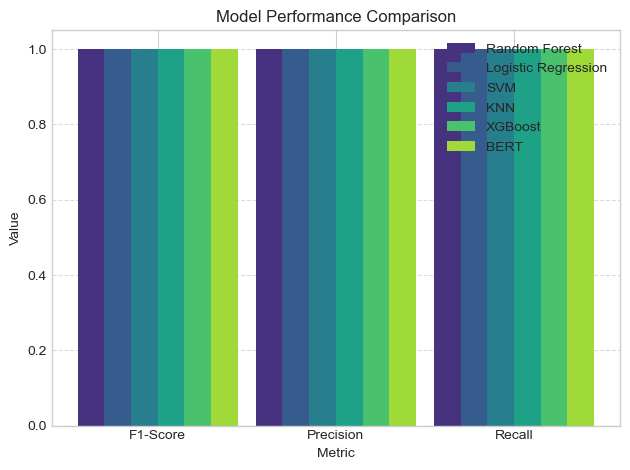

In [53]:
for i, model in enumerate(results_df['Model']):
    values = results_df.iloc[i][['F1-Score', 'Precision', 'Recall']].values
    plt.bar(x + (i - 2.5) * width, values, width, label=model)

plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_comparison.png')

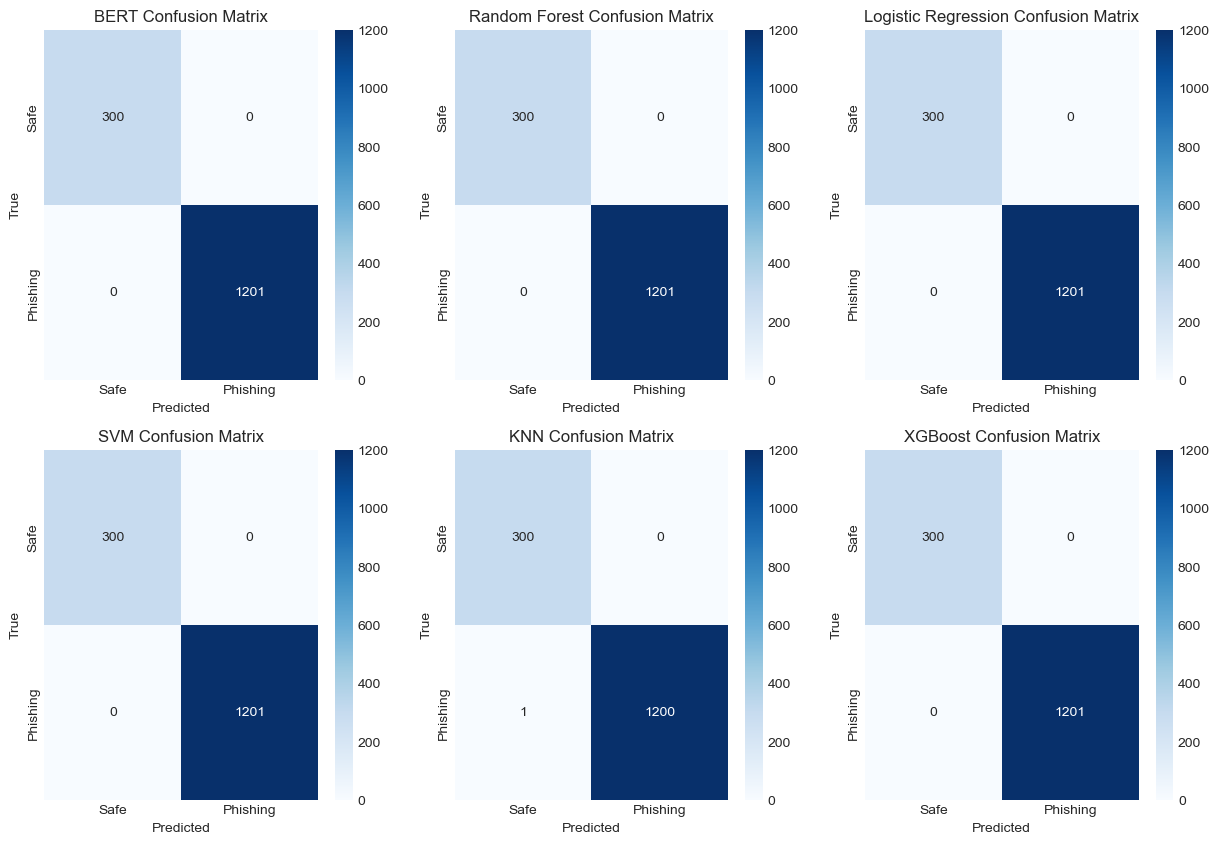

In [54]:
# Plot confusion matrices for each model
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Safe', 'Phishing'],
                yticklabels=['Safe', 'Phishing'])
    axes[idx].set_title(f'{name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

In [55]:
# Hide empty subplots
for idx in range(len(predictions), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('confusion_matrices.png')

<Figure size 640x480 with 0 Axes>

In [56]:
# Select the best model based on F1-Score
best_model_name = results_df.loc[results_df['F1-Score'].idxmax()]['Model']
print(f"\nBest model (based on F1-Score): {best_model_name}")


Best model (based on F1-Score): Random Forest
